In [142]:
from model.utils import Logger as LOG
LOG.measure_perf = True # ! ENABLE PERFORMANCE MONITORING
from model.utils import monitor_perf

from model.sign_to_text import SignToText
from model.speech_to_text import SpeechToText
from deep_translator import GoogleTranslator

from media_processing.video import webm_bytes_to_tensor, tensor_to_webm_bytes, load_mp4video_from_file, VideoPipeline
from media_processing.video import write_webm_bytes_to_file, read_webm_bytes_from_file
from media_processing.audio import webm_to_waveform

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame as df

import uuid

red = '\033[91m'
ylw = '\033[93m'
grn = '\033[92m'
blk = '\033[0m'

color_map = [
    "#46bdc6",
    "#4285F4",
    "#ff6d01",
    # "#F4B400",
    "#0F9D58",
]

google_languages = {
            "US": "en",
            "UK": "en",
            "DE": "de",
            "DK": "da"}

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.rcParams["figure.figsize"] = np.array([16, 9]) / 2
plt.rcParams["figure.autolayout"] = True

In [6]:
train = [
    f'./experiment-data/experiment_vids/train{i}.mp4'
    for i in range(100)
]
load_video = lambda video_idx: load_mp4video_from_file(video_idx)

# Downsampling visualizations

In [7]:
def show_frame(video_array,idx=0):
    plt.imshow(video_array[idx].detach().numpy())
    
def show_seq(video_array, idx_offset):
    w = 35
    h = 35
    fig = plt.figure(figsize=(w, h))
    columns = 10
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        show_frame(video_array, idx=i + idx_offset)
    plt.show()

# Performance tests GPU [Sign2Text]

In [34]:
import torch

In [35]:
slt_model = SignToText(device = 'cuda' if torch.cuda.is_available() else 'cpu')

Loading state dicts individually
Training backbone from scratch
Training head network from scratch
Freezing up to block 4 in S3D backbone
Loading model from pretrained checkpoint!


In [ ]:
assert slt_model.model.device.type[:4] == 'cuda', "Not on GPU yet!"

In [10]:
pipe = VideoPipeline(W_in=260, H_in=210, WH_out=224, k_t=1.)

In [37]:
# ! when not performing benchmarks
# del slt_model

In [24]:
""" Takes in a list of videos and monitors performance on the full SLT pipeline, using GPU acceleration """
def test_suite_slt_gpu(videos, repetitions=1, pipe=None, slt_model=None):
    assert pipe is not None and slt_model is not None, "Missing VideoPipeline or Sign2Text model."
    test_suite_ID = uuid.uuid4()
    for rep in range(repetitions):
        print(f"{red}Test Suite [{test_suite_ID}] {ylw}@ {grn}ITER {rep+1}{blk}")
        for video_idx in videos:
            repetition_ID = uuid.uuid4()
            _video = load_video(video_idx)
            # ? get webm bytes, just like we receive via websocket
            data = tensor_to_webm_bytes(_video)

            # video = webm_bytes_to_tensor(data)
            video = monitor_perf(webm_bytes_to_tensor, 
                                 data, width = 224, height = 224, 
                                 test_suite_ID=test_suite_ID, 
                                 repetition_ID=repetition_ID, 
                                 _input=len(data))
            
            # video = video.to('cuda') # ! send to GPU
            video = monitor_perf(video.to, 'cuda', # ! send to GPU
                                test_suite_ID=test_suite_ID, 
                                 repetition_ID=repetition_ID,
                                 variation='Send Video To GPU',
                                 _input=video.shape[0])

            # video, num_frames = pipe(video, to_file=False, output_length=True)
            video, num_frames = monitor_perf(pipe.__call__, 
                                             video, to_file=False, output_length=True, 
                                             variation=f"VideoPipeline, k_t={pipe.k_t}", 
                                             _input=video.shape[0], 
                                             test_suite_ID=test_suite_ID, 
                                             repetition_ID=repetition_ID)

            # y = slt_model(video, num_frames)[0]
            y = monitor_perf(slt_model.inference, video, num_frames, 
                             variation="Sign2Text", 
                             _input=int(num_frames[0]), 
                             test_suite_ID=test_suite_ID, 
                             repetition_ID=repetition_ID)[0]

            lang_from, lang_to = "DE", "US"
            # y = GoogleTranslator(source=google_languages[lang_from], target=google_languages[lang_to]).translate(y)
            monitor_perf(GoogleTranslator(source=google_languages[lang_from], target=google_languages[lang_to]).translate, y, 
                         variation="Google Translate", 
                         test_suite_ID=test_suite_ID, 
                         repetition_ID=repetition_ID)
        LOG.perfmon_step()
    print(f"{red}Test Suite [{test_suite_ID}] {ylw}@ {grn}FINISHED{blk}")


In [ ]:
""" Reset metrics (stores backup) """
LOG.reset_perf_metrics()

""" Run performance tests for 3 values of k_t """
pipe.k_t = 1.
test_suite_slt_gpu(train, repetitions=1, slt_model=slt_model, pipe=pipe)
pipe.k_t = .5
test_suite_slt_gpu(train, repetitions=1, slt_model=slt_model, pipe=pipe)
pipe.k_t = .33333
test_suite_slt_gpu(train, repetitions=1, slt_model=slt_model, pipe=pipe)

""" Save .csv-file """
LOG.save_perf_metrics()

In [23]:
""" see dataframe as table """
LOG.perf_metrics

,Function Name,Variation,Input Dims,time,perf_counter,process_time,Test Suite ID,Repetition ID
0,webm_bytes_to_tensor,None,151052,0.059362,0.059362,0.018372,eadfa273-2f99-4b8a-b377-5cc29d6cde27,1d5c3ea3-72f1-4a69-bbea-dd226769fb95
1,__call__,"VideoPipeline, k_t=1.0",100,0.028024,0.028025,0.125492,eadfa273-2f99-4b8a-b377-5cc29d6cde27,1d5c3ea3-72f1-4a69-bbea-dd226769fb95
2,inference,Sign2Text,tensor(100.),3.151217,3.151194,7.446397,eadfa273-2f99-4b8a-b377-5cc29d6cde27,1d5c3ea3-72f1-4a69-bbea-dd226769fb95
3,translate,Google Translate,None,0.106313,0.106313,0.012794,eadfa273-2f99-4b8a-b377-5cc29d6cde27,1d5c3ea3-72f1-4a69-bbea-dd226769fb95


In [ ]:
""" manually save dataframe """
LOG.save_perf_metrics()

In [ ]:
""" reset dataframe - will save current contents to backups folder """ 
LOG.reset_perf_metrics()

### Delete model from memory:

In [25]:
# get the model out of memory :D
del slt_model

# Perform analysis on GPU data:

In [ ]:
LOG.load_perf_metrics(file_name="perf_metrics_GPU")


In [42]:
LOG.perf_metrics.drop("Unnamed: 0", axis=1, inplace=True)
LOG.perf_metrics.drop("time", axis=1, inplace=True)
LOG.perf_metrics.drop("process_time", axis=1, inplace=True)
LOG.perf_metrics

,Function Name,Variation,Input Dims,perf_counter,Test Suite ID,Repetition ID
0,webm_bytes_to_tensor,NaN,150149.0,0.061839,d4b58333-ba8c-44e5-88e2-ec132bae6dbe,a6d147f6-06c6-45b1-8bc1-b2eb543dd281
1,to,Send Video To GPU,100.0,0.008215,d4b58333-ba8c-44e5-88e2-ec132bae6dbe,a6d147f6-06c6-45b1-8bc1-b2eb543dd281
2,__call__,"VideoPipeline, k_t=1.0",100.0,0.001030,d4b58333-ba8c-44e5-88e2-ec132bae6dbe,a6d147f6-06c6-45b1-8bc1-b2eb543dd281
3,inference,Sign2Text,100.0,2.026159,d4b58333-ba8c-44e5-88e2-ec132bae6dbe,a6d147f6-06c6-45b1-8bc1-b2eb543dd281
4,translate,Google Translate,NaN,0.138397,d4b58333-ba8c-44e5-88e2-ec132bae6dbe,a6d147f6-06c6-45b1-8bc1-b2eb543dd281
...,...,...,...,...,...,...
1495,webm_bytes_to_tensor,NaN,173463.0,0.089160,8bf6a0a4-b666-4c35-9580-d5bd9a0c42a5,c697bb75-1371-4366-afe9-b1aa1b4bdcf4
1496,to,Send Video To GPU,116.0,0.002624,8bf6a0a4-b666-4c35-9580-d5bd9a0c42a5,c697bb75-1371-4366-afe9-b1aa1b4bdcf4
1497,__call__,"VideoPipeline, k_t=0.33333",116.0,0.000432,8bf6a0a4-b666-4c35-9580-d5bd9a0c42a5,c697bb75-1371-4366-afe9-b1aa1b4bdcf4
1498,inference,Sign2Text,38.0,0.531467,8bf6a0a4-b666-4c35-9580-d5bd9a0c42a5,c697bb75-1371-4366-afe9-b1aa1b4bdcf4


In [52]:
pm = LOG.perf_metrics.copy()
pm_aggregated_time = pm.groupby("Repetition ID")["perf_counter"].sum()
pm_aggregated_time 

Repetition ID
022a43e0-40a0-4613-a0a0-156c02dd6114    0.651396
0494b7dc-0cf7-4004-b5d1-f776c44cee9d    1.437680
05a27b0f-a4cf-4fa1-9d41-ef2789fc71dd    1.061920
09c452d3-1d30-4267-a5fc-67c035a6f1b7    1.203078
0a575b5b-5d13-49c8-9929-eba2f0761938    0.432921
                                          ...   
fbd3f8e5-b160-489e-82db-f7f8a061d7fb    1.228635
fbe7b3b5-8b14-4511-960f-077e4ee3db77    1.198211
fbeda5b8-d275-48a6-bf9c-f3bd6177715f    1.148333
fcd8d725-43de-4878-94be-3110e1242bdd    1.708521
fd8f94c7-fa1e-4b55-9680-003588c9574b    1.089877
Name: perf_counter, Length: 300, dtype: float64

In [50]:
import pandas as pd

In [66]:
df = pm.dropna()

# Assuming your original DataFrame is called 'df'
# And the columns are "Function Name", "Variation", "Input Dims", "perf_counter", "Test Suite ID", "Repetition ID"

# Define a custom aggregation function
def custom_aggregation(group):
    aggregated_data = {
        'Total perf_counter': group['perf_counter'].sum(),
        'Input Dims': group.loc[group['Variation'].str.contains('VideoPipeline'), 'Input Dims'].dropna().tolist(),
        'Variation': group['Variation']
    }
    return pd.Series(aggregated_data, index=['Total perf_counter', 'Input Dims', 'Variation'])

# Group by "Repetition ID" and apply the custom aggregation function
aggregated_df = df.groupby("Repetition ID").apply(custom_aggregation)

# Reset the index
aggregated_df = aggregated_df.reset_index()

# Print the resulting aggregated DataFrame
aggregated_df

,Repetition ID,Total perf_counter,Input Dims,Variation
0,022a43e0-40a0-4613-a0a0-156c02dd6114,0.300680,[24.0],751 Send Video To GPU 752 VideoPipe...
1,0494b7dc-0cf7-4004-b5d1-f776c44cee9d,0.759551,[192.0],311 Send Video To GPU 312 VideoPipe...
2,05a27b0f-a4cf-4fa1-9d41-ef2789fc71dd,0.848135,[176.0],641 Send Video To GPU 642 VideoPipe...
3,09c452d3-1d30-4267-a5fc-67c035a6f1b7,0.821573,[144.0],531 Send Video To GPU 532 VideoPipe...
4,0a575b5b-5d13-49c8-9929-eba2f0761938,0.212821,[24.0],251 Send Video To GPU 252 VideoPipe...
...,...,...,...,...
295,fbd3f8e5-b160-489e-82db-f7f8a061d7fb,0.668893,[116.0],831 Send Video To GPU 832 VideoPipe...
296,fbe7b3b5-8b14-4511-960f-077e4ee3db77,0.764311,[116.0],71 Send Video To GPU 72 VideoPipeli...
297,fbeda5b8-d275-48a6-bf9c-f3bd6177715f,0.483215,[44.0],351 Send Video To GPU 352 VideoPipe...
298,fcd8d725-43de-4878-94be-3110e1242bdd,0.931692,[200.0],986 Send Video To GPU 987 VideoPipe...


In [85]:
aggregated_df['k_t'] = aggregated_df['Variation'][0].values[1][len("VideoPipeline, k_t="):]
aggregated_df


,Repetition ID,Total perf_counter,Input Dims,Variation,Extracted Variation,k_t
0,022a43e0-40a0-4613-a0a0-156c02dd6114,0.300680,[24.0],751 Send Video To GPU 752 VideoPipe...,"VideoPipeline, k_t=0.5",0.5
1,0494b7dc-0cf7-4004-b5d1-f776c44cee9d,0.759551,[192.0],311 Send Video To GPU 312 VideoPipe...,"VideoPipeline, k_t=0.5",0.5
2,05a27b0f-a4cf-4fa1-9d41-ef2789fc71dd,0.848135,[176.0],641 Send Video To GPU 642 VideoPipe...,"VideoPipeline, k_t=0.5",0.5
3,09c452d3-1d30-4267-a5fc-67c035a6f1b7,0.821573,[144.0],531 Send Video To GPU 532 VideoPipe...,"VideoPipeline, k_t=0.5",0.5
4,0a575b5b-5d13-49c8-9929-eba2f0761938,0.212821,[24.0],251 Send Video To GPU 252 VideoPipe...,"VideoPipeline, k_t=0.5",0.5
...,...,...,...,...,...,...
295,fbd3f8e5-b160-489e-82db-f7f8a061d7fb,0.668893,[116.0],831 Send Video To GPU 832 VideoPipe...,"VideoPipeline, k_t=0.5",0.5
296,fbe7b3b5-8b14-4511-960f-077e4ee3db77,0.764311,[116.0],71 Send Video To GPU 72 VideoPipeli...,"VideoPipeline, k_t=0.5",0.5
297,fbeda5b8-d275-48a6-bf9c-f3bd6177715f,0.483215,[44.0],351 Send Video To GPU 352 VideoPipe...,"VideoPipeline, k_t=0.5",0.5
298,fcd8d725-43de-4878-94be-3110e1242bdd,0.931692,[200.0],986 Send Video To GPU 987 VideoPipe...,"VideoPipeline, k_t=0.5",0.5


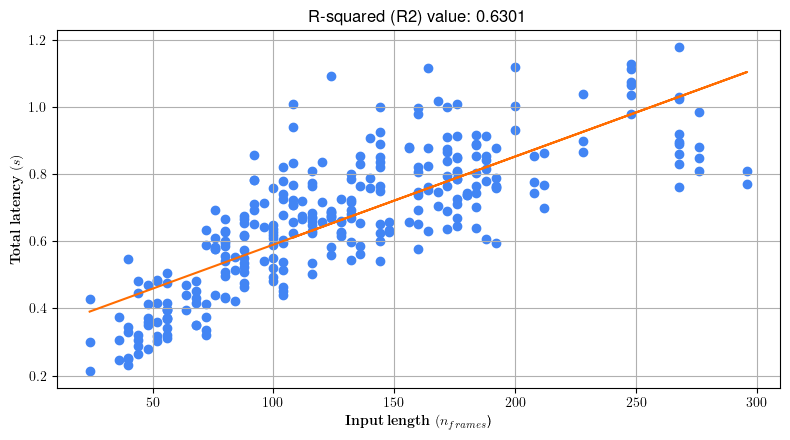

In [144]:
input_dims = np.array([x[0] for x in aggregated_df['Input Dims']])
perf_counter = aggregated_df['Total perf_counter']

def drop_max_val(arr1, arr2):
    idx_to_drop = np.argmax(arr2)
    return (np.concatenate((arr1[:idx_to_drop], arr1[idx_to_drop+1:])), \
    np.concatenate((arr2[:idx_to_drop], arr2[idx_to_drop+1:])))

for _ in range(4):
    input_dims, perf_counter = drop_max_val(input_dims, perf_counter)

plt.scatter(input_dims, perf_counter, color=color_map[1])

# Linear Regression
slope, intercept = np.polyfit(input_dims, perf_counter, 1)
line = slope * input_dims + intercept

# Calculate the total sum of squares (TSS)
tss = np.sum((perf_counter - np.mean(perf_counter))**2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((perf_counter - line)**2)

# Calculate the R2 value
r2 = 1 - (rss / tss)

# Print the R2 value
plt.title(f"R-squared (R2) value: {np.round(r2,4)}")

plt.plot(input_dims, line, color=color_map[2], label='Linear Trendline')


plt.xlabel("$\mathbf{Input~length}~(n_{frames}$)")
plt.ylabel("$\mathbf{Total~latency}~(s)$")
plt.grid()

plt.show()

283

In [110]:
pm

,Function Name,Variation,Input Dims,perf_counter,Test Suite ID,Repetition ID
0,webm_bytes_to_tensor,NaN,150149.0,0.061839,d4b58333-ba8c-44e5-88e2-ec132bae6dbe,a6d147f6-06c6-45b1-8bc1-b2eb543dd281
1,to,Send Video To GPU,100.0,0.008215,d4b58333-ba8c-44e5-88e2-ec132bae6dbe,a6d147f6-06c6-45b1-8bc1-b2eb543dd281
2,__call__,"VideoPipeline, k_t=1.0",100.0,0.001030,d4b58333-ba8c-44e5-88e2-ec132bae6dbe,a6d147f6-06c6-45b1-8bc1-b2eb543dd281
3,inference,Sign2Text,100.0,2.026159,d4b58333-ba8c-44e5-88e2-ec132bae6dbe,a6d147f6-06c6-45b1-8bc1-b2eb543dd281
4,translate,Google Translate,NaN,0.138397,d4b58333-ba8c-44e5-88e2-ec132bae6dbe,a6d147f6-06c6-45b1-8bc1-b2eb543dd281
...,...,...,...,...,...,...
1495,webm_bytes_to_tensor,NaN,173463.0,0.089160,8bf6a0a4-b666-4c35-9580-d5bd9a0c42a5,c697bb75-1371-4366-afe9-b1aa1b4bdcf4
1496,to,Send Video To GPU,116.0,0.002624,8bf6a0a4-b666-4c35-9580-d5bd9a0c42a5,c697bb75-1371-4366-afe9-b1aa1b4bdcf4
1497,__call__,"VideoPipeline, k_t=0.33333",116.0,0.000432,8bf6a0a4-b666-4c35-9580-d5bd9a0c42a5,c697bb75-1371-4366-afe9-b1aa1b4bdcf4
1498,inference,Sign2Text,38.0,0.531467,8bf6a0a4-b666-4c35-9580-d5bd9a0c42a5,c697bb75-1371-4366-afe9-b1aa1b4bdcf4
